In [1]:
## PHYS 139 Final Project: attempting to recreate results from "Introducing the DREAMS Project: DaRk mattEr and Astrophysics with Machine Learning and Simulations" paper
## goals: to recreate the results from Section 4.2: "Inference with Convolutional Neural Networks"

In [2]:
## importing common packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys, os, time, optuna
import utils as U
import architecture

C:\Users\steph\miniconda3\envs\stephconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## defining global plotting parameters (can adjust as needed)

from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

## Loading in the images and playing around with them:
**Parameter Names and Meanings:**

* omegaM = matter density parameter, representing the fraction of the Universe's total energy density contributed by all matter. This is measured as a ratio of the Universe's mean matter density to the critical density (the density required to make the Universe spatially flat). Most measurements place the value at about 0.27. If omegaM > 1, the Universe has a closed geometry (will eventually collapse). If omegaM < 1, the Universe has an open geometry (will keep expanding forever). If omegaM = 1, the Universe has a perfectly flat geometry (expansion will slow but still never stop completely).

* sigma8 = cosmological constant that quantifies the amplitude of matter density fluctuations on a scale of 8 megaparsecs / (
Mpc). It is used to measure the "clumpiness" of the universe, representing how much matter has clustered together into structures like galaxies and galaxy clusters. Measurements from the early universe suggest a higher degree of clumpiness (a higher sigma8 value), while measurements of nearby galaxies and clusters indicate a lower level of clumpiness (a lower sigma8 value).

* SNe = parameter that controls the strength of supernova explosions in the TNG simulations. This has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* SNv = parameter that controls the strength of supernova wind velocity in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included

* AGN = parameter that controls the strength of active galactic nucleus (typically supermassive black hole) feedback in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* 1/m_WDM = 1 over the WDM particle mass, expressed often in keV or simply in this form.

In [4]:
raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(raw_images.shape)

(15000, 256, 256)


(1000, 6)


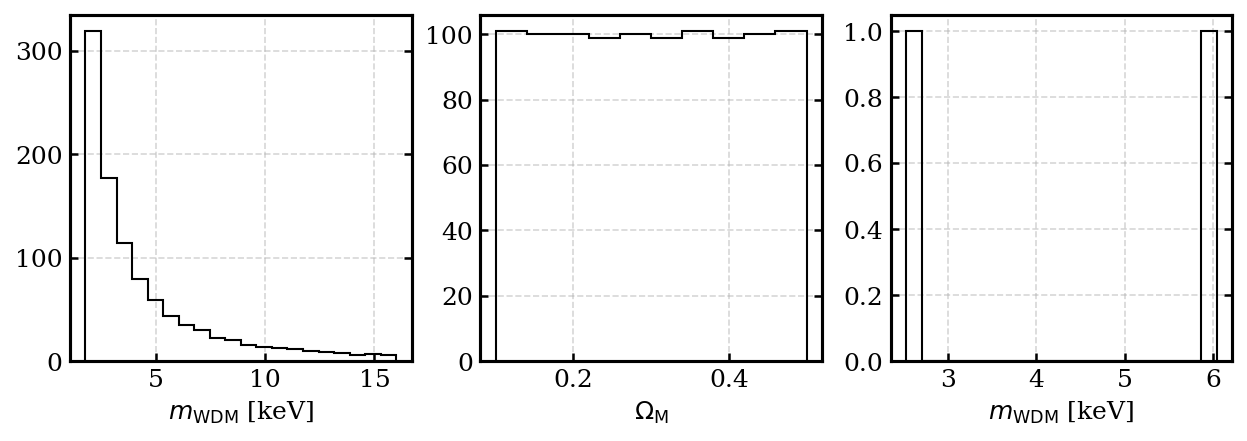

In [5]:
## recreating the 3 plots in the "data_play_around" notebook:
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (10,3))

## plot 1:
bins = 20

WDM_params_test = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params_test.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params_test = (WDM_params_test * (maximum - minimum)) + minimum
ax[0].hist((1./WDM_params_test[:, 5]), bins=bins, color='k', histtype='step', lw=6, density=False, log=False) # plot a histogram of the WDM masses, log scale histogram
ax[0].grid(True, ls='--', alpha=0.5, which='both')
ax[0].set_xlabel(r'$m_{\rm WDM}$ [keV]')

## plot 2:
ax[1].hist(WDM_params_test[:, 0], bins=10, color='k', histtype='step', lw=6, density=False, log=False)
ax[1].grid(True, ls='--', alpha=0.5, which='both')
ax[1].set_xlabel(r'$\Omega_{\rm M}$')

## plot 3:
epsilon = 0.005
OmegaM_range = [0.49-epsilon,0.49+epsilon]
sigma8_range = [0.8-4*epsilon,0.8+4*epsilon]
WDM_masses_test = (1./WDM_params_test[:, 5])[(WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1])]

ax[2].hist(WDM_masses_test, bins=bins, color='k', histtype='step', lw=6, density=False, log=False)
ax[2].grid(True, ls='--', alpha=0.5, which='both')
ax[2].set_xlabel(r'$m_{\rm WDM}$ [keV]')

plt.show()

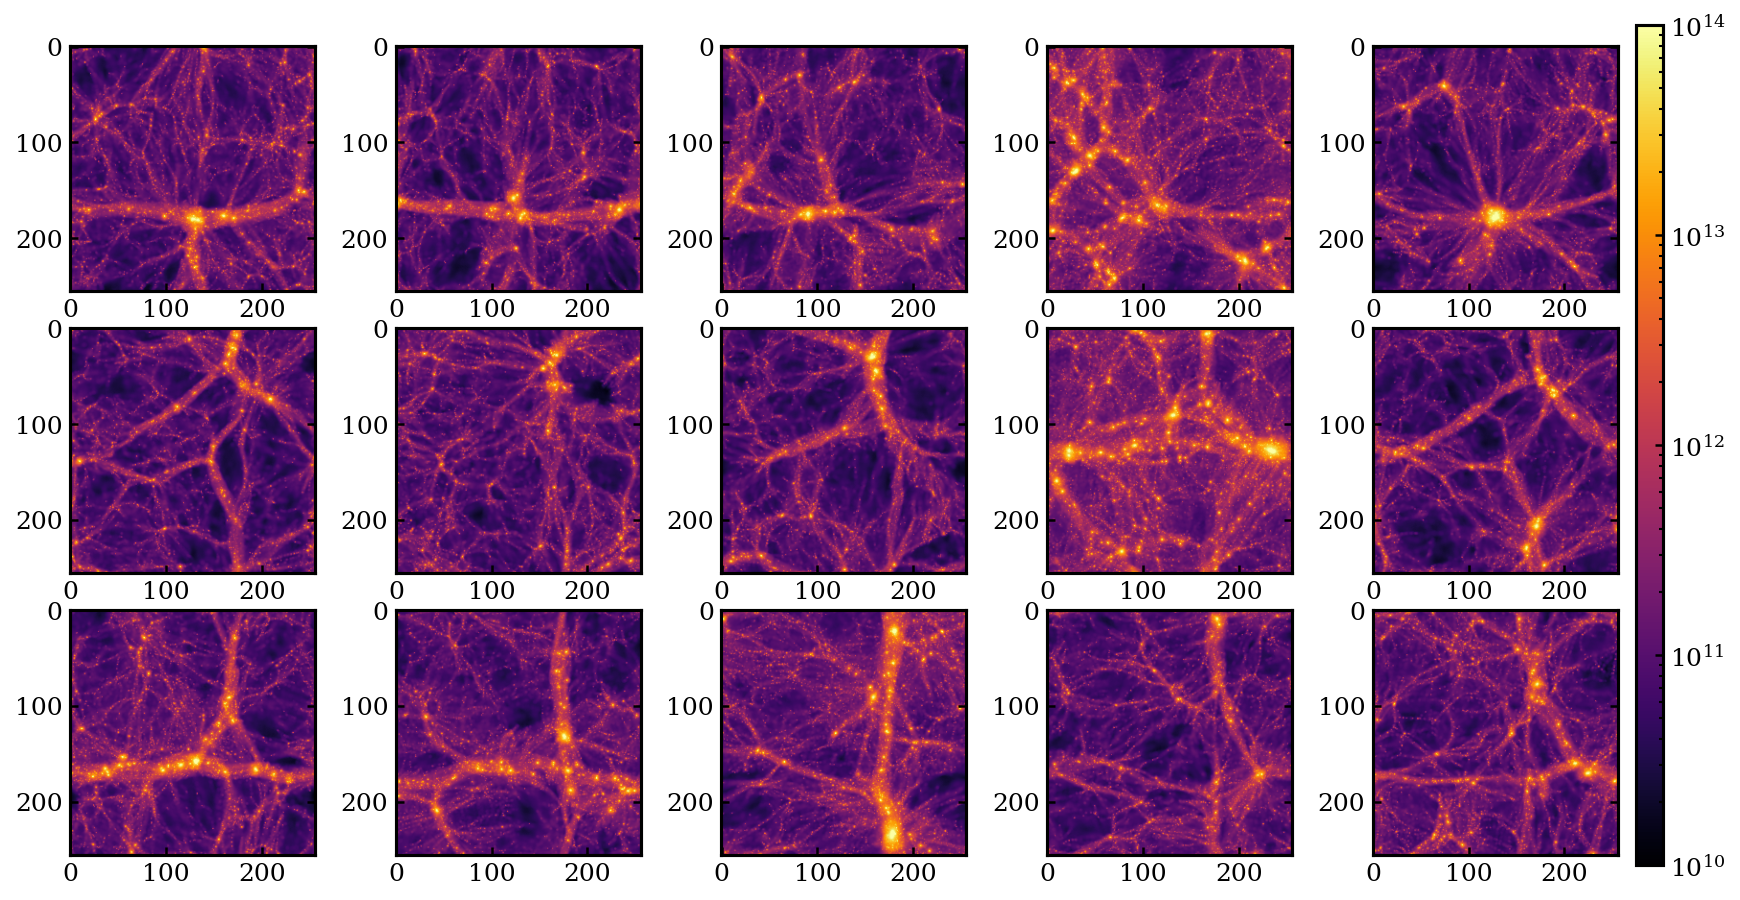

In [6]:
# visualise the first raw image, using log scale
mass_index = 5
epsilon = 0.005
omegam_mean = 0.49
sigma8_mean = 0.8
OmegaM_range = [omegam_mean-epsilon,omegam_mean+epsilon]
sigma8_range = [sigma8_mean-4*epsilon,sigma8_mean+4*epsilon]

valid_indices = ((WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1]))

# finding the nth largest value in an array
index = np.argsort(WDM_params_test[:,mass_index])[-1]
error = 5e-1
target = 6 # keV
#index = np.where((WDM_params[:,mass_index] >= 1./(target + error)) & (WDM_params[:,mass_index] <= 1./(target - error)) & valid_indices)[0][0]
index = 0
#print(index)
vmin = 1e10; vmax = 1e14
#print(f'Params: {WDM_params[index]}')

## PLOT ONLY ONE PLOT:
#fig, axs = plt.subplots(figsize=(4,4), constrained_layout = True)
#print(f'WDM mass: {1./WDM_params[index][mass_index]} keV, OmegaM: {WDM_params[index][np.where(np.array(WDM_param_names) == "OmegaM")[0][0]]}, Sigma8: {WDM_params[index][np.where(np.array(WDM_param_names) == "sigma8")[0][0]]}')
#im = axs.imshow(raw_images[15*index + 3], norm=LogNorm(vmin=1e10, vmax=1e14), cmap='inferno')
#divider = make_axes_locatable(axs)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(im, cax = cax)
#plt.show()

## LOOPING THROUGH FIRST 15 PLOTS:
fig, axes = plt.subplots(ncols = 5, nrows = 3, figsize=(14,7))
#plt.title(f'WDM mass: {1./WDM_params[index][mass_index]} eV')
for i, ax in enumerate(axes.flat):
    im = ax.imshow(raw_images[15*index + i], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')

fig.subplots_adjust(wspace = 0.0025, hspace = 0.15)
cax = fig.add_axes([0.89, 0.1, 0.0125, 0.8])
fig.colorbar(im, cax=cax)
#plt.savefig("added_colorbar.png")
plt.show()

## Data Preprocessing:

RAW IMAGE DATA SHAPE: (15000, 256, 256)
ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: (1000, 256, 256)


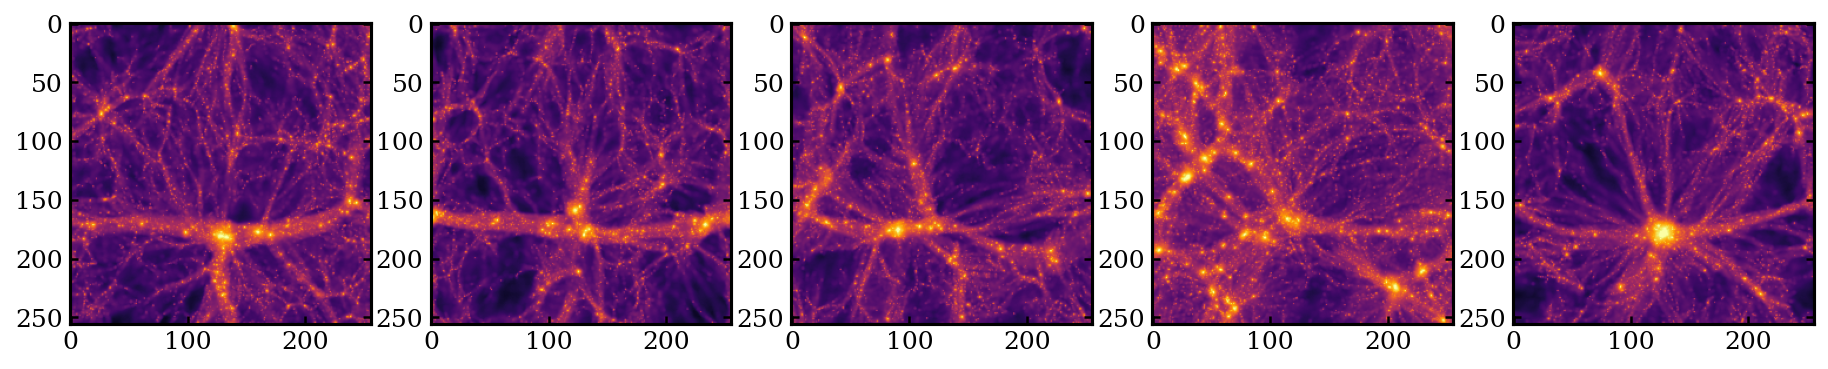

In [7]:
## data stored as 15,000 individual elements in a numpy array
## each simulation is stored as 15 slices along some axis
## for computation time, it would make sense to just take the (first?) image from each simulation
## let's make that dataset now:

raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(f"RAW IMAGE DATA SHAPE: {raw_images.shape}")

counter = 0
only_first_raw_images = []
for img_index in range(0, len(raw_images), 15):
    only_first_raw_images.append(raw_images[counter])
    counter += 1

print(f"ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: {np.array(only_first_raw_images).shape}")
    
## if we did this correctly, we should get the same row of images as in the previous step
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (15,3))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(only_first_raw_images[i], norm = LogNorm(vmin = vmin, vmax = vmax), cmap = 'inferno')

#plt.savefig("test.png")
plt.show()

## problem fixed, had a bug w/ the counter
## now it works as intended

## Building the 2-D CNN:

**MODEL BUILDING HELP:** (Some info taken from PHYS139 lectures / GitHub.io page)

"There are four principal components to a CNN: a convolutional layer, a nonlinear activation function, a pooling or downsampling operation, and a fully connected layer for classification."
* Most TensorFlow models start with a Sequential layer, but you don't really need to do anything with this (besides name it if you want...)
* Conv2D --> takes in an integer for filters (first #), a "kernel" size (basically the size of the convolution window), a padding ("valid" = none or "same" = zero_padding), and (optional) activation function to use after convolution. "Once learned the kernels within the convolutional layer can appear as physically intuitive operations on the images such as edge detection filters."
* BatchNormalization --> tries to maintain the mean output close to 0 (stabilizes things)
* Activation --> "As with traditional neural networks, a nonlinear activation function is applied to the individual pixels in the resulting feature maps."
* MaxPooling2D --> "The pooling in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region of interest (e.g., a pixel window). The summary can be the average pixel value but more commonly the maximum pixel value is preserved (max pooling) in the downsampling. This pooling of the feature maps reduces the size of the resulting network and makes the network less sensitive to small translations or distortions between images."

In [8]:
## TODO
# tag images with number
# try to do a 90-5-5 split amongst training, validation, testing --> also probably do k-fold
# feed into model --> it will spit out 1/mass

In [9]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf

In [10]:
img_height, img_width = 256, 256

# get the total number of sims and maps:
splits = 15
WDM_params = np.loadtxt("WDM_TNG_params_1000.txt")  # simulations parameters, NOT maps parameters
total_sims, total_maps, num_params = WDM_params.shape[0], WDM_params.shape[0]*splits, WDM_params.shape[1]
params = np.zeros((total_maps, num_params), dtype = np.float32)
for i in range(total_sims):
    for j in range(splits):
        params[i * splits + j] = WDM_params[i]  # filling up the full params array for each individual image/map

print(f"Params Correct Shape if params.shape = (15000, 6) --> params.shape = {params.shape}")

Params Correct Shape if params.shape = (15000, 6) --> params.shape = (15000, 6)


In [11]:
# loading in parameters:
WDM_params = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params = (WDM_params * (maximum - minimum)) + minimum

(1000, 6)


In [12]:
# use for preprocessing the same way as in the paper:
only_first_images_formatted = np.log10(only_first_raw_images)
mean = np.mean(only_first_images_formatted)
std = np.std(only_first_images_formatted)
only_first_images_formatted = (only_first_images_formatted - mean) / std

X = only_first_images_formatted
y = WDM_params[:, 5]  # no knowledge of any of the other columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical

## using the hands-on portion from class for guidance:
def test_CNN(input_shape=(256, 256, 1), n_classes: int = 1):

    model = Sequential(name="test_CNN")
    # input: 256x256 images with 1 channel -> (256, 256, 1) tensors

    # conv. block 1:
    model.add(Conv2D(8, (1, 1), input_shape=(256, 256, 1), activation = "relu", padding = "same", name = "conv_1"))  # this applies 8 convolution filters of size 1x1 each
    model.add(BatchNormalization(axis = 3, name = "bn_1"))
    model.add(Activation("relu", name = "activation_1"))
    model.add(MaxPooling2D(pool_size = (2,2), name = "pool_1"))

    model.add(Dense(64, activation ='relu', name = "dense_1"))

    # conv. block 2:
    model.add(Conv2D(8, (1, 1), activation = "relu", padding = "same", name = "conv_2")) # same as above
    model.add(BatchNormalization(axis = 3, name = "bn_2"))
    model.add(Activation("relu", name = "activation_2"))
    model.add(MaxPooling2D(pool_size = (2,2), name = "pool_2"))

    model.add(Flatten(name ="flatten_2"))
    model.add(Dense(64, activation ='relu', name = "dense_2"))
    
    ## output layer
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Dense(n_classes, activation = activation, name = "fc_out"))
    
    return model

In [14]:
test_model = test_CNN()
test_model.summary()

C:\Users\steph\miniconda3\envs\stephconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "test_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 256, 256, 8)         │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1 (BatchNormalization)            │ (None, 256, 256, 8)         │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128, 128, 64)        │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 128, 128, 8)         │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2 (BatchNormalization)            │ (None, 128, 128, 8)         │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,098,457 (8.00 MB)

 Trainable params: 2,098,425 (8.00 MB)

 Non-trainable params: 32 (128.00 B)

In [15]:
test_model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['mse'])

In [16]:
# training parameters:
batch_size = 128
min_lr = 1e-9
epochs = 100

test_model.fit(X_train, y_train, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - loss: 1.5136 - mse: 0.1170 - val_loss: 0.6906 - val_mse: 0.0535
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - loss: 0.6903 - mse: 0.0554 - val_loss: 0.6873 - val_mse: 0.0519
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - loss: 0.6576 - mse: 0.0393 - val_loss: 0.6664 - val_mse: 0.0414
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - loss: 0.6243 - mse: 0.0224 - val_loss: 0.6621 - val_mse: 0.0393
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - loss: 0.6167 - mse: 0.0198 - val_loss: 0.6636 - val_mse: 0.0400
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - loss: 0.6114 - mse: 0.0178 - val_loss: 0.6535 - val_mse: 0.0351
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - loss: 0.6048 - mse: 0.0150 - val_loss: 0.6506 - val_mse: 0.0337
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - loss: 0.5977 - mse: 0.0121 - val_loss: 0.6428 - val_mse: 0.0300
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/

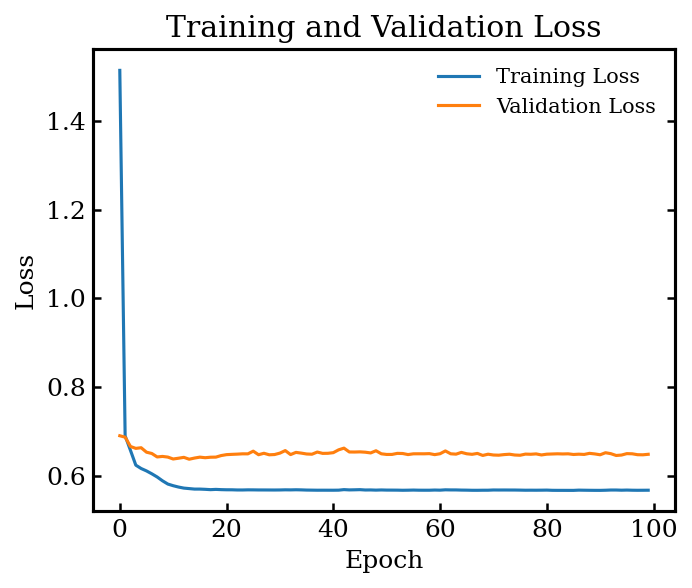

In [17]:
train_loss = test_model.history.history['loss']
val_loss = test_model.history.history['val_loss']
train_mse = test_model.history.history['mse']
val_mse = test_model.history.history['mse']

plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("training and validation loss")
plt.show()

In [18]:
y_pred = test_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


0 0.18286091 0.324738 0.14187708910751345
1 0.39569747 0.939494 0.5437965255203248
2 0.33049315 0.7317 0.40120684785842897
3 0.22835837 0.097413 -0.13094537304592133
4 0.3395721 0.411881 0.07230889816856384
5 0.4306355 0.792262 0.36162648812484743
6 0.36979792 0.503963 0.13416508477973943
7 0.40412366 0.135301 -0.2688226639022827
8 0.271287 0.019395 -0.2518919942188263
9 0.25654152 0.653681 0.397139479642868
10 0.45402494 0.923915 0.4698900592708588
11 0.5080428 0.309159 -0.1988838123474121
12 0.3121803 0.24469 -0.0674903104877472
13 0.15979391 0.613352 0.4535580866355896
14 0.23982556 0.839214 0.5993884383573532
15 0.2394733 0.458833 0.21935970180797576
16 0.1506835 0.564479 0.4137954926767349
17 0.17802407 0.199723 0.02169893152523042
18 0.25303298 0.472459 0.21942601765060427
19 0.3688817 0.856746 0.4878642975769043
20 0.46340683 0.667277 0.20387016897392274
21 0.22559604 0.036896 -0.18870004048728944
22 0.07760077 0.260255 0.18265423030138017
23 0.32037836 0.878917 0.55853863686752

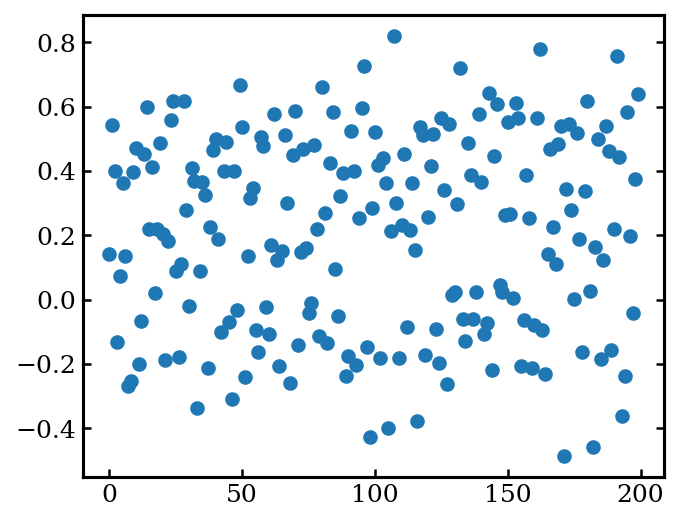

In [19]:
WDM_params_true = np.loadtxt('WDM_TNG_params_1000.txt')
inv_mass = WDM_params_true[:, 5]

for index, model_pred in enumerate(y_pred):
    print(index, model_pred[0], inv_mass[index], inv_mass[index] - model_pred[0])
    plt.scatter(index, inv_mass[index] - model_pred[0], color = "tab:blue")